In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dates
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import pandas_datareader as web
import seaborn as sns

In [46]:
%pylab inline
%matplotlib inline
style.use('ggplot')
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [75]:
ruta = "http://dreamlife.es/ripple.csv"
dfTransacciones = pd.read_csv(ruta,delimiter=";", decimal=",")

ruta = "http://dreamlife.es/ballenas.csv"
dfTransBallenas = pd.read_csv(ruta,delimiter=";", decimal=",")

ruta = "http://dreamlife.es/tweets.csv"
dfTweets = pd.read_csv(ruta,delimiter=";", decimal=",")

<div class="alert alert-block alert-info">
USAMOS UN GRAFICO DE PLOTLY DE CANDLESTICK PARA VISUALIZAR LOS PRECIOS DESDE EL COMIENZO DEL BITCOIN
</div>

In [48]:
plotly.tools.set_credentials_file(username='juan.roncero', api_key='xxx')

In [51]:
df = web.DataReader("aapl", 'morningstar').reset_index()

trace = go.Candlestick(x=df.Date,
                       open=df.Open,
                       high=df.High,
                       low=df.Low,
                       close=df.Close)
data = [trace]
py.iplot(data, filename='simple_candlestick')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~juan.roncero23/0 or inside your plot.ly account where it is named 'simple_candlestick'


### CREAMOS INDICES Y ORDENAMOS

In [10]:
# TRANSFORM
dfTransacciones["FECHA"] = pd.to_datetime(dfTransacciones["FECHA"])
dfTransacciones.index = pd.to_datetime(dfTransacciones["FECHA"], unit='s')
dfTransacciones = dfTransacciones.sort_values('FECHA')

dfTransBallenas["FECHA"] = dfTransBallenas["FECHA_OPERACION"]
dfTransBallenas["FECHA"] = pd.to_datetime(dfTransBallenas["FECHA"])
dfTransBallenas.index = pd.to_datetime(dfTransBallenas["FECHA"], unit='s')
dfTransBallenas = dfTransBallenas.sort_values('FECHA')

dfTweets["FECHA"] = pd.to_datetime(dfTweets["FECHA"])
dfTweets.index = pd.to_datetime(dfTweets["FECHA"], unit='s')
dfTweets = dfTweets.sort_values('FECHA')
dfTweets = dfTweets[dfTweets["ID_CUENTA"]==1]

### FUNCIONES DE AGRUPACION DE DATOS USASAS POSTERIORMENTE

In [11]:
def agrupaTweets(df, minutos):
    
    df1 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).mean()
    df1 = df1["SENTIMIENTO"]
    
    return df1

def agrupaBallenas(df, minutos):
    
    df['CANTIDAD_TOTAL'] = df["CANTIDAD"]
        
    df1 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).count()
    df1["NUM_TRANSACCIONES"] = df1['CANTIDAD']
    df1 = df1["NUM_TRANSACCIONES"] 
    
    df2 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).sum()
    df2 = df2['CANTIDAD_TOTAL']
    
    df = pd.concat([df1, df2],axis=1)
    
    return df

def agrupaDatos(df, minutos):
    
    #df = dfTransacciones
    dfCompras = df[df["TIPOTRANSACCION"]==False]
    dfVentas = df[df["TIPOTRANSACCION"]==True]

    # NUEVAS COLUMNAS
    df["HIGH"] = df["PRICE"]
    df['LOW'] = df["PRICE"]
    df['CANTIDAD_TOTAL'] = df["AMOUNT"]
    dfCompras['NUM_T_COMPRA'] = dfCompras["AMOUNT"]
    dfVentas['NUM_T_VENTA'] = dfVentas["AMOUNT"]

    # MAXIMO, MINIMO, CANTIDAD_TOTAL
    df1 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).agg({'HIGH':np.max, 'LOW':np.min,'CANTIDAD_TOTAL':np.sum})

    # NÚMERO DE TRANSACCIONES DE COMPRA
    df2 = dfCompras.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).count()
    df2 = df2['NUM_T_COMPRA']

    # NÚMERO DE TRANSACCIONES DE VENTA
    df3 = dfVentas.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).count()
    df3 = df3['NUM_T_VENTA']

    # CANTIDAD TOTAL DE MONEDA COMPRADA
    df4 = dfCompras.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).sum() 
    df4["CANTIDAD_COMPRA"] = df4['AMOUNT']
    df4 = df4['CANTIDAD_COMPRA']

    # CANTIDAD TOTAL DE MONEDA VENDIDA
    df5 = dfVentas.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).sum()
    df5["CANTIDAD_VENTA"] = df5['AMOUNT']
    df5 = df5['CANTIDAD_VENTA']

    # OPEN
    df6 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).first()
    df6["OPEN"] = df6["PRICE"]
    df6= df6["OPEN"]

    # CLOSE
    df7 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).last()
    df7["CLOSE"] = df7["PRICE"]
    df7= df7["CLOSE"]

    df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=1)

    # NUEVAS COLUMNAS CALCULADAS
    df['VAR_MAX'] = (df['HIGH'] - df['LOW'])/df['LOW'] * 100
    df['VAR_INTERVALO'] = (df['CLOSE'] - df['OPEN'])/df['OPEN'] * 100

    # FILTRAMOS COLUMNAS 
    df = df[['NUM_T_COMPRA','NUM_T_VENTA','CANTIDAD_COMPRA','CANTIDAD_VENTA','VAR_MAX','VAR_INTERVALO','OPEN', 'CLOSE']]

    df = df.dropna()
    
    return df

<div class="alert alert-block alert-info"> 
VAMOS A ESTUDIAR EL RANGO DE NUESTRAS VARIABLES
</div>

In [37]:
minutosDeAgrupado = 30
dfAgrupadoUsuarios = agrupaDatos(dfTransacciones, minutosDeAgrupado)
dfAgrupadoTweets = agrupaTweets(dfTweets, minutosDeAgrupado)
dfAgrupadoBallenas = agrupaBallenas(dfTransBallenas, minutosDeAgrupado)

In [36]:
dfAgrupadoUsuarios.describe()

,NUM_T_COMPRA,NUM_T_VENTA,CANTIDAD_COMPRA,CANTIDAD_VENTA,VAR_MAX,VAR_INTERVALO,OPEN,CLOSE
count,4025.000000,4025.000000,4.025000e+03,4.025000e+03,4025.000000,4025.000000,4025.000000,4025.000000
mean,137.938634,128.663106,2.025207e+05,2.076862e+05,1.361426,0.004502,0.721716,0.721700
std,163.356244,132.137270,2.983430e+05,2.855578e+05,0.944709,0.984366,0.162517,0.162444
min,1.000000,1.000000,9.770147e+01,1.339999e+02,0.111801,-6.735446,0.457810,0.456000
25%,53.000000,57.000000,5.074581e+04,5.099685e+04,0.758874,-0.449578,0.605070,0.605390
50%,94.000000,88.000000,1.104388e+05,1.137208e+05,1.116898,-0.007954,0.686560,0.686770
75%,168.000000,149.000000,2.378037e+05,2.455608e+05,1.690605,0.436416,0.854830,0.854730
max,4647.000000,1589.000000,5.374804e+06,4.156773e+06,11.290323,8.732117,1.175500,1.172920


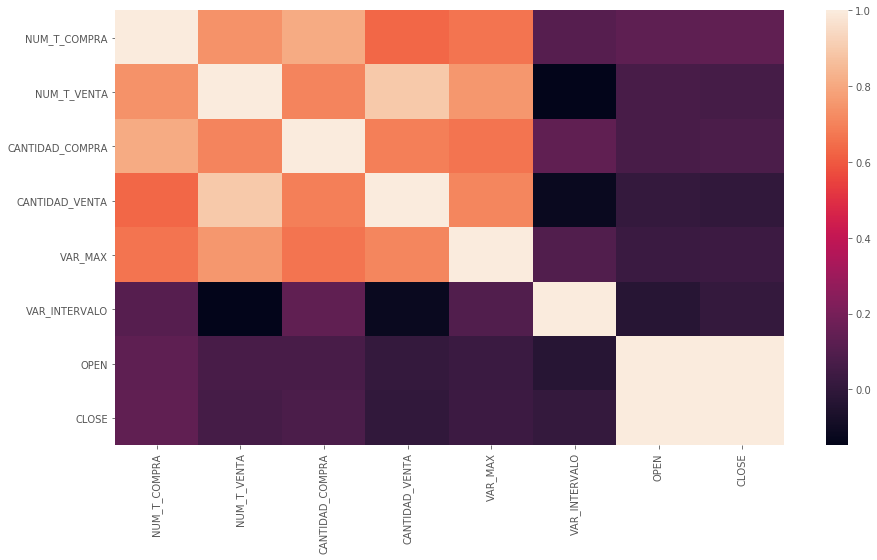

In [73]:
#plt.matshow(dfAgrupadoUsuarios.corr())
ax = sns.heatmap(dfAgrupadoUsuarios.corr())

Text(0,0.5,'Damped oscillation')

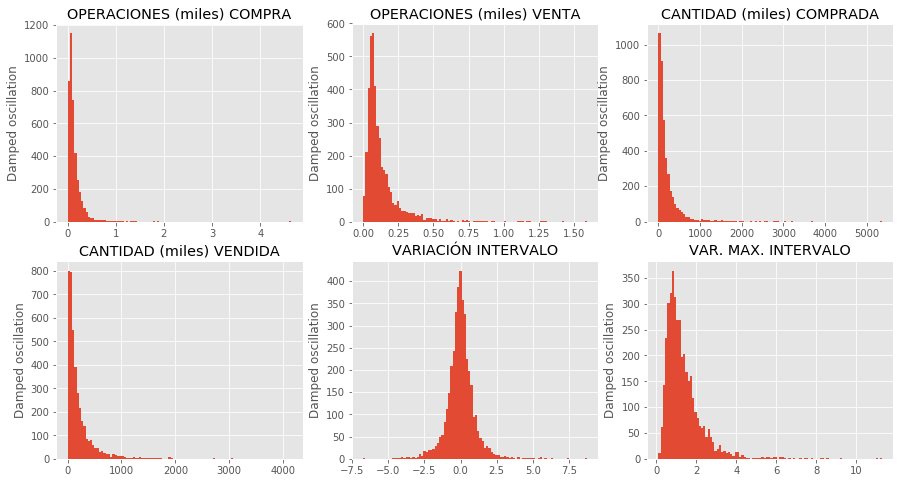

In [35]:
pylab.rcParams['figure.figsize'] = (15,8)

plt.subplot(2, 3, 1)
plt.hist(dfAgrupadoUsuarios['NUM_T_COMPRA'].values / 1000, bins=100)
plt.title('OPERACIONES (miles) COMPRA')
plt.ylabel('Damped oscillation')

plt.subplot(2, 3, 2)
plt.hist(dfAgrupadoUsuarios['NUM_T_VENTA'].values / 1000, bins=100)
plt.title('OPERACIONES (miles) VENTA')
plt.ylabel('Damped oscillation')

plt.subplot(2, 3, 3)
plt.hist(dfAgrupadoUsuarios['CANTIDAD_COMPRA'].values / 1000, bins=100)
plt.title('CANTIDAD (miles) COMPRADA')
plt.ylabel('Damped oscillation')

plt.subplot(2, 3, 4)
plt.hist(dfAgrupadoUsuarios['CANTIDAD_VENTA'].values / 1000, bins=100)
plt.title('CANTIDAD (miles) VENDIDA')
plt.ylabel('Damped oscillation')

plt.subplot(2, 3, 5)
plt.hist(dfAgrupadoUsuarios['VAR_INTERVALO'].values, bins=100)
plt.title('VARIACIÓN INTERVALO')
plt.ylabel('Damped oscillation')

plt.subplot(2, 3, 6)
plt.hist(dfAgrupadoUsuarios['VAR_MAX'].values, bins=100)
plt.title('VAR. MAX. INTERVALO')
plt.ylabel('Damped oscillation')

<div class="alert alert-block alert-info">
COMPARAMOS LAS GRANDES OPERACIONES (>70.000 ripples) PARA VER SI TIENEN CORRELACION CON EL PRECIO
<br><br> Las operaciones de compra aparecerán en verde y las de venta en rojo
</div> 

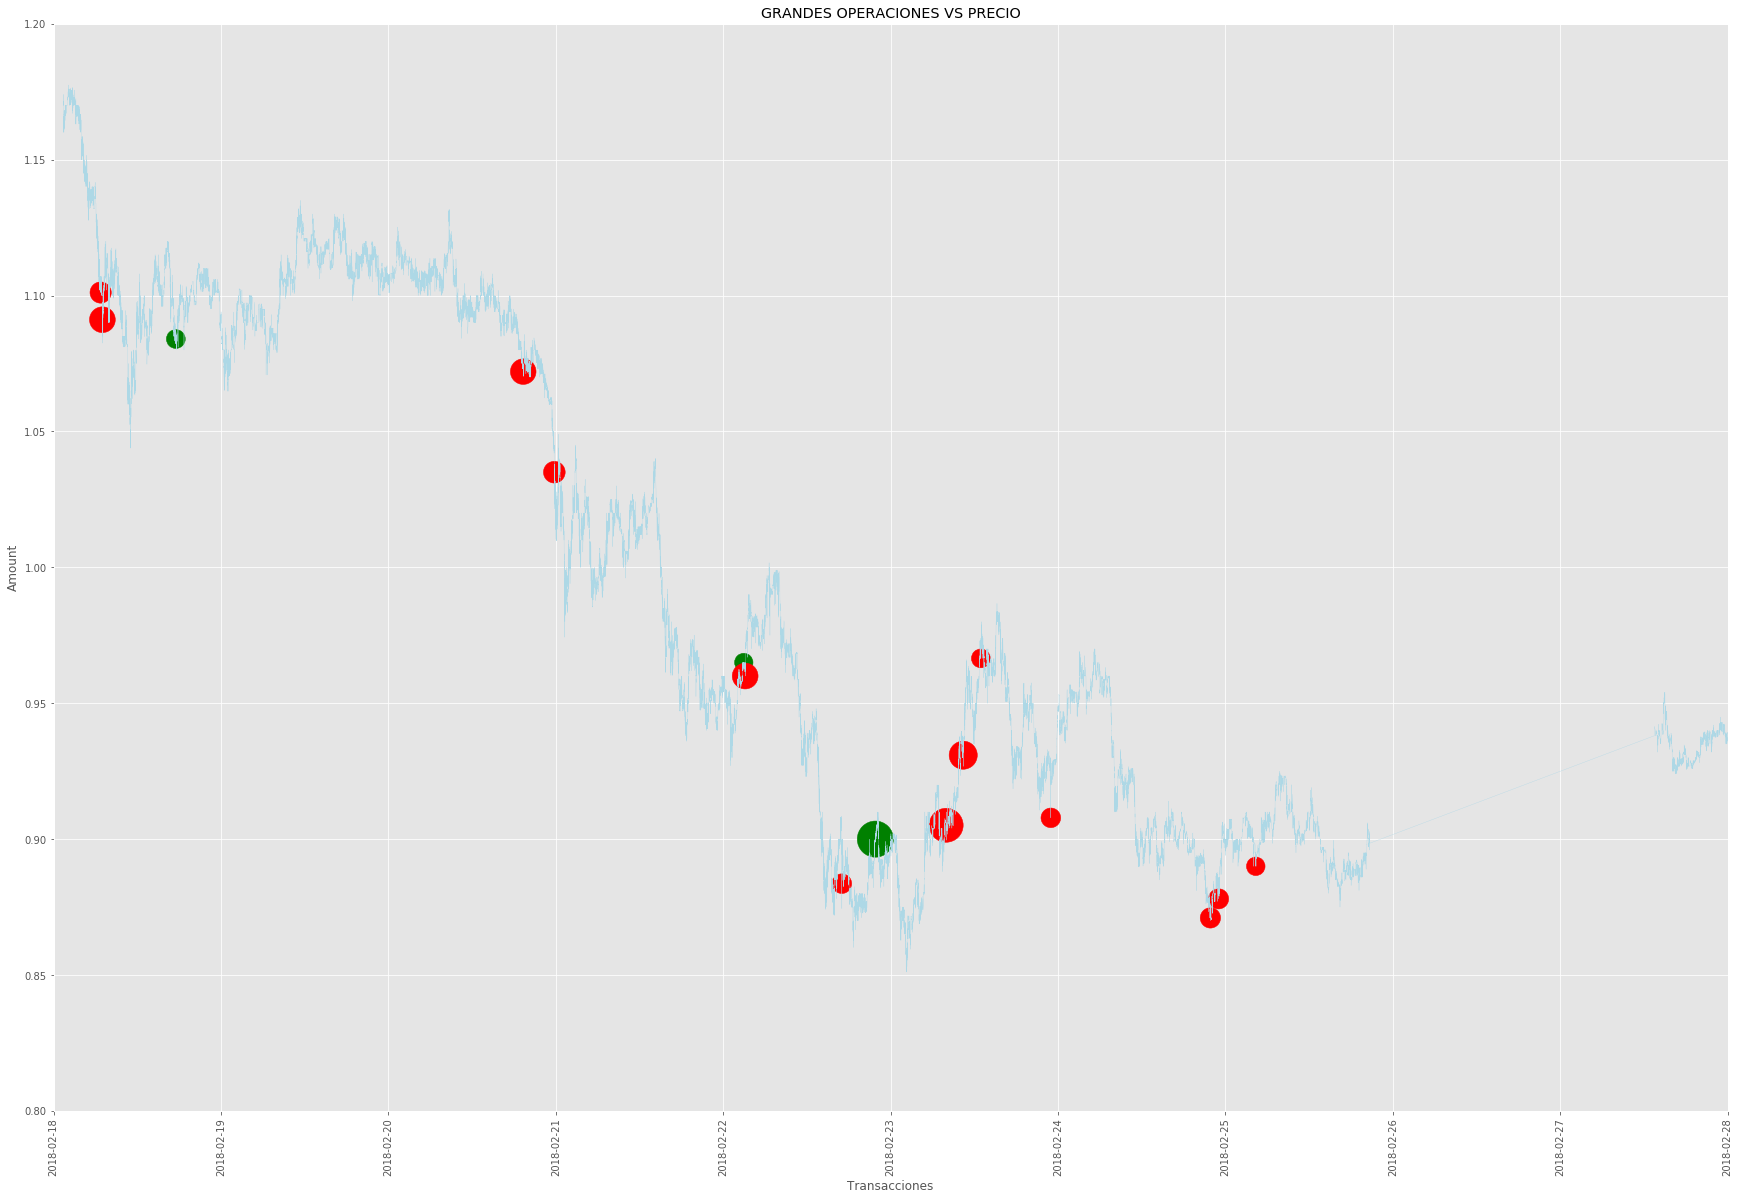

In [38]:
dfGrandesOpsCompras = dfTransacciones[(dfTransacciones["AMOUNT"] > 100000) & (dfTransacciones["TIPOTRANSACCION"]==False)]
dfGrandesOpsVentas = dfTransacciones[(dfTransacciones["AMOUNT"] > 100000) & (dfTransacciones["TIPOTRANSACCION"]==True)]

# GRANDES OPERACIONES VS PRECIO
pylab.rcParams['figure.figsize'] = (30, 20)
plt.xticks(rotation='vertical')
plt.xlabel('Transacciones')
plt.ylabel('Amount')
plt.title('GRANDES OPERACIONES VS PRECIO')

x1 = [pd.to_datetime(d) for d in dfGrandesOpsCompras['FECHA']]
x2 = [pd.to_datetime(d) for d in dfGrandesOpsVentas['FECHA']]
s1 = [d/300 for d in dfGrandesOpsCompras['AMOUNT']]
s2 = [d/300 for d in dfGrandesOpsVentas['AMOUNT']]

plt.scatter(x1,dfGrandesOpsCompras["PRICE"],color=['green'],s =s1)
plt.scatter(x2,dfGrandesOpsVentas["PRICE"],color=['red'],s =s2)
plt.plot(dfTransacciones['FECHA'], dfTransacciones['PRICE'],linewidth=0.3,color='lightblue')
plt.ylim(.8, 1.2)
plt.xlim('2018-02-18','2018-02-28')

plt.show()

<div class="alert alert-block alert-success">
En el grafico anterior podemos ver que coincide, por lo general, que cuando hay caída libre de precios no se producen compras. Se ve que si tiene relación y utilizaremos posteriormente en los modelos estas características.
</DIV>

<div class="alert alert-block alert-info">
COMPARAMOS LAS GRANDES DE BALLENAS (>1 millon ripples) PARA VER SI TIENEN CORRELACION CON EL PRECIO
<br><br> A día de hoy no distinguimos compras de ventas, ya que son transacciones entre carteras, y aunque se puede identificar cuales son relativas a Exchanges, no por ello es indicativo que la operación sea compra o venta. Los Exchangues utilizan las mismas carteras para muchos usuarios. 
</div>

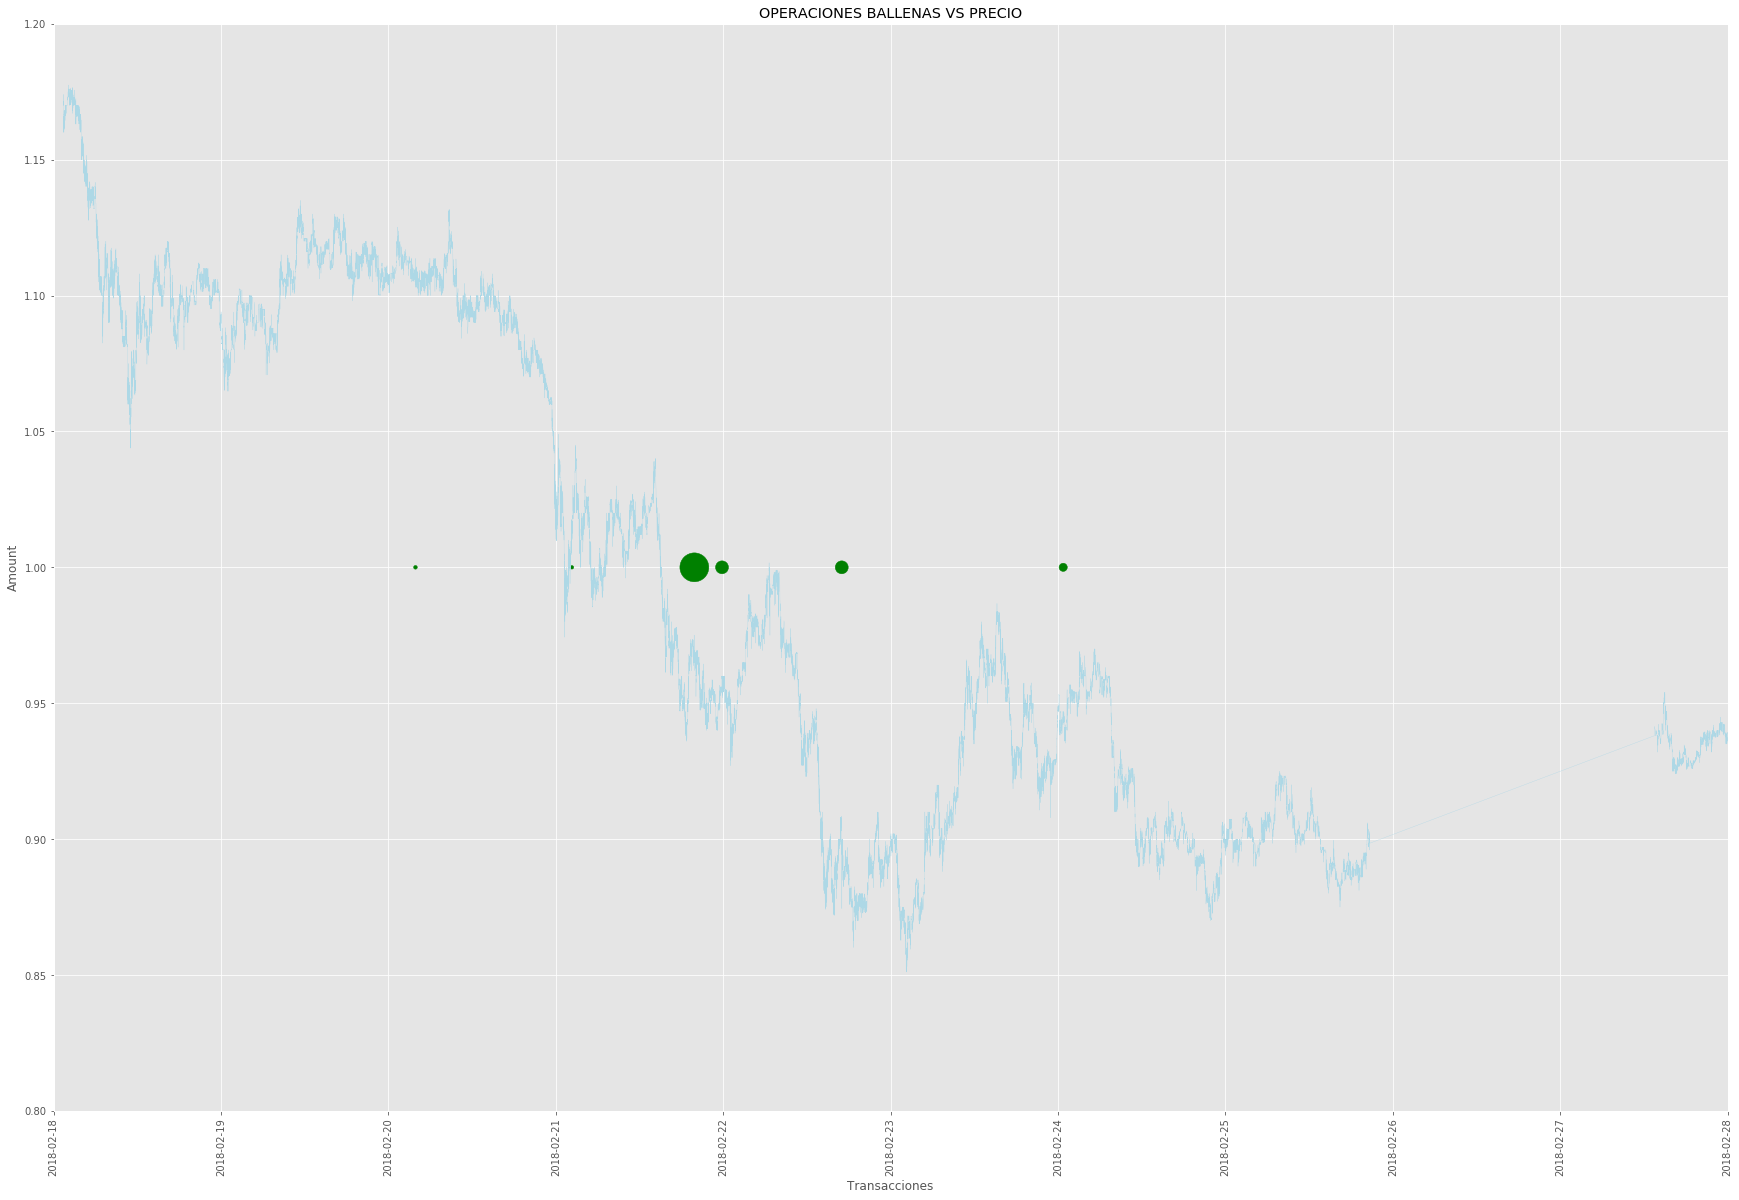

In [19]:
# GRANDES OPERACIONES VS PRECIO
pylab.rcParams['figure.figsize'] = (30, 20)
plt.xticks(rotation='vertical')
plt.xlabel('Transacciones')
plt.ylabel('Amount')
plt.title('OPERACIONES BALLENAS VS PRECIO')


x1 = [pd.to_datetime(d) for d in dfTransBallenas['FECHA_OPERACION']]
s1 = [d/300000 for d in dfTransBallenas['CANTIDAD']]
dfTransBallenas["PRICE"] = 1

plt.scatter(x1,dfTransBallenas["PRICE"],color=['green'],s =s1)
plt.plot(dfTransacciones['FECHA'], dfTransacciones['PRICE'],linewidth=0.3,color='lightblue')
plt.ylim(.8, 1.2)
plt.xlim('2018-02-18','2018-02-28')

plt.show()

<div class="alert alert-block alert-success">
Como se muestra, no tenemos suficiente información actualmente para poder estudiar su efecto o correlación en el mercado. 
Las operaciones de ballenas son de más de 1 millón de XRP y suelen tener una frecuencia de una semanal.
</DIV>

<div class="alert alert-block alert-info">
COMPARAMOS LOS TWEETS (MEDIA DE SENTIMIENTO) CON LOS DATOS DE TRANSACCIONES AGRUPADOS
</div>

In [20]:
dfAgrupadoTweets.columns = ['SENTIMIENTOO']
dfAgrupadoTweets = dfAgrupadoTweets.dropna()
dfAgrupadoTweets.head(1)

dfAgrupadoTweets = pd.Series.to_frame(dfAgrupadoTweets)

dfAgrupadoTweetsPos = dfAgrupadoTweets[dfAgrupadoTweets["SENTIMIENTO"]>0]
dfAgrupadoTweetsNeg = dfAgrupadoTweets[dfAgrupadoTweets["SENTIMIENTO"]<0]

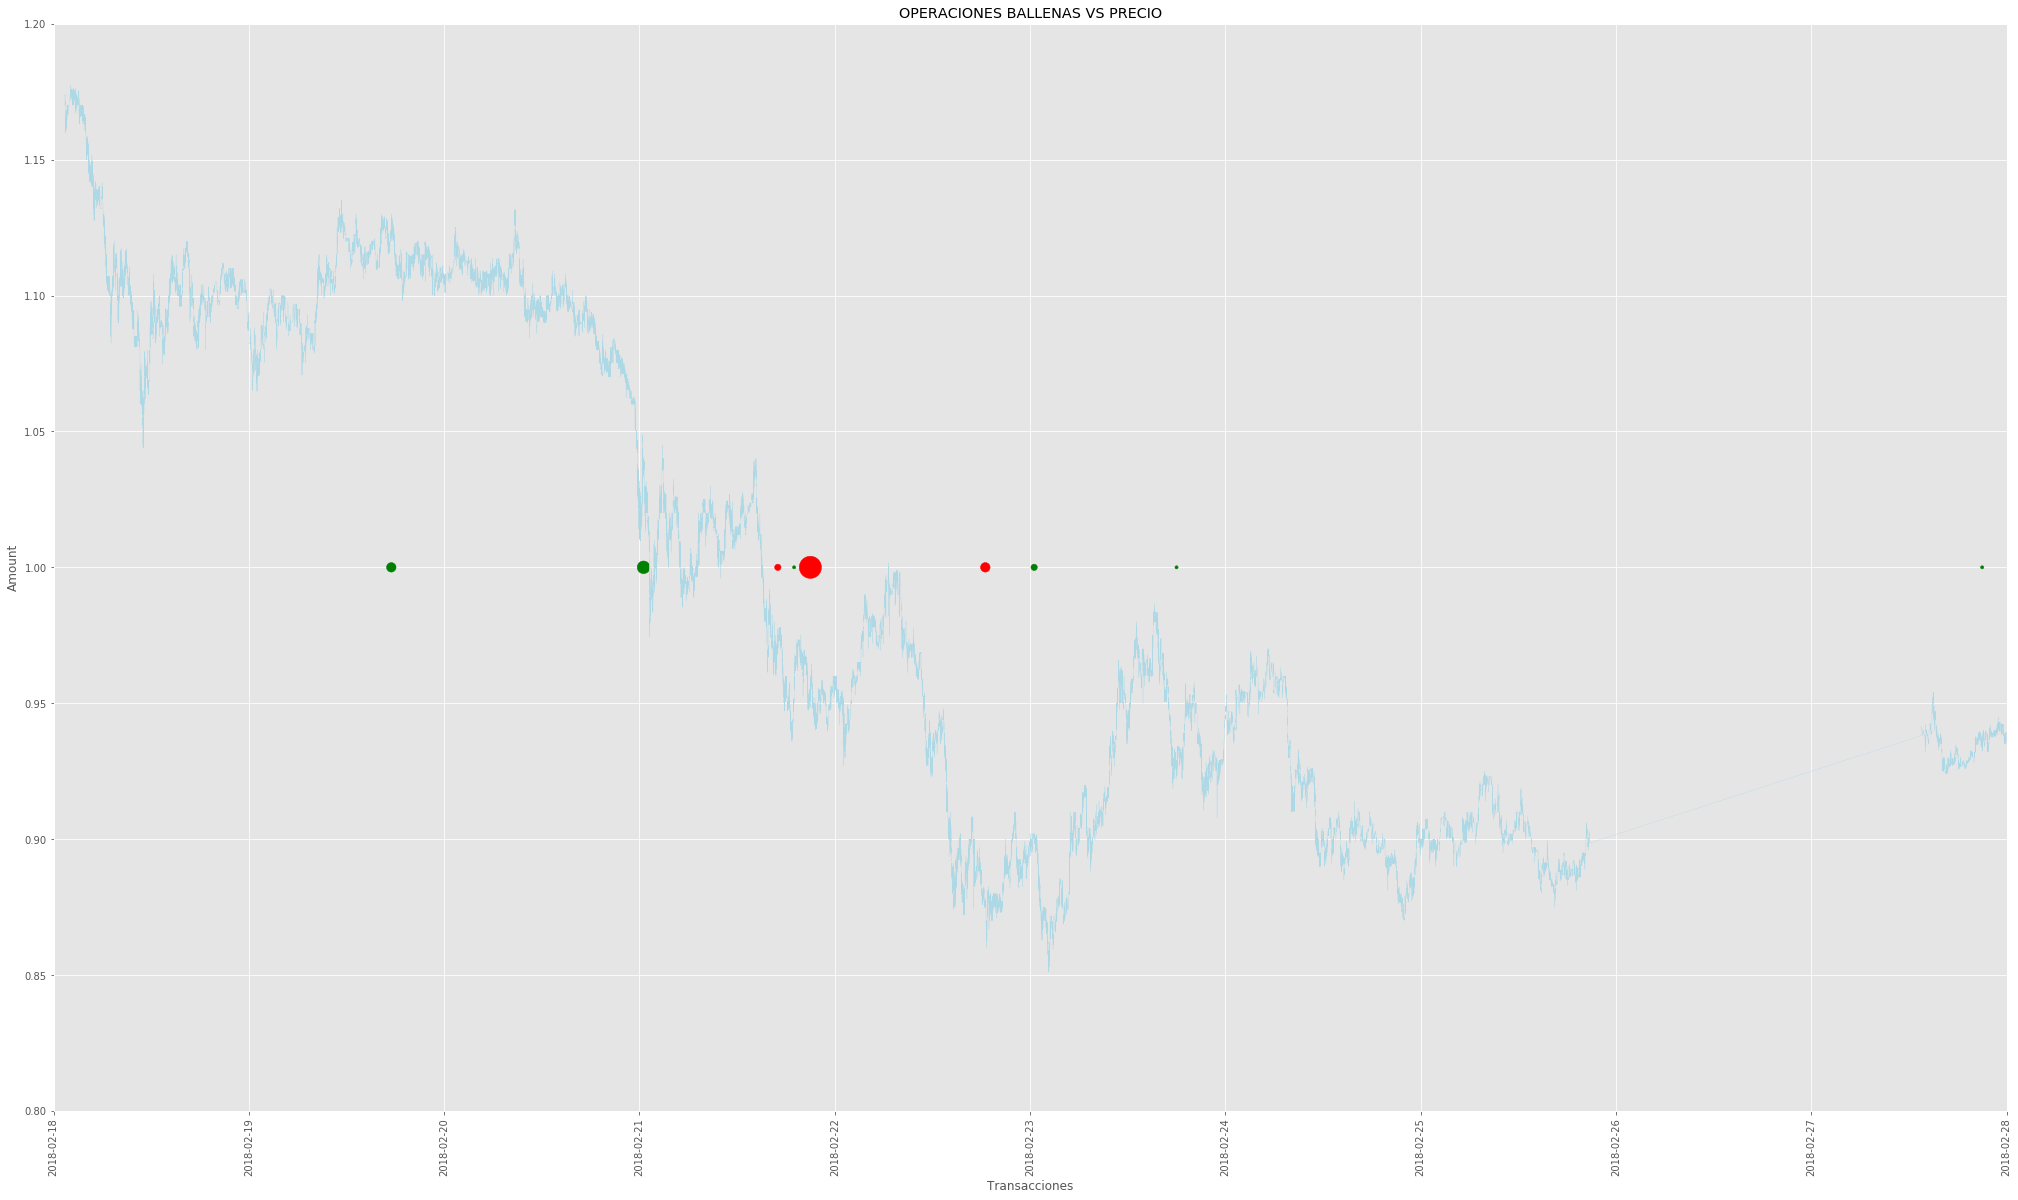

In [21]:
pylab.rcParams['figure.figsize'] = (35, 20)
plt.xticks(rotation='vertical')
plt.xlabel('Transacciones')
plt.ylabel('Amount')
plt.title('OPERACIONES BALLENAS VS PRECIO')

x1 = [pd.to_datetime(d) for d in dfAgrupadoTweetsPos.index]
s1 = [d**2*1000 for d in dfAgrupadoTweetsPos['SENTIMIENTO']]
dfAgrupadoTweetsPos["PRICE"] = 1

x2 = [pd.to_datetime(d) for d in dfAgrupadoTweetsNeg.index]
s2 = [d**2*1000 for d in dfAgrupadoTweetsNeg['SENTIMIENTO']]
dfAgrupadoTweetsNeg["PRICE"] = 1

plt.scatter(x1, dfAgrupadoTweetsPos["PRICE"], color=['green'], s=s1)
plt.scatter(x2, dfAgrupadoTweetsNeg["PRICE"], color=['red'], s=s2)
plt.plot(dfTransacciones['FECHA'], dfTransacciones['PRICE'],linewidth=0.3,color='lightblue')

plt.ylim(.8, 1.2)
plt.xlim('2018-02-18','2018-02-28')

plt.show()

<div class="alert alert-block alert-success">
Como se muestra, no tenemos suficiente información como en el caso de las ballenas, pero si se puede comprobar que el momento de concentración de mayor número de tweets negativos ,coincide con el momento previo a una bajada de precio considerable. Sin duda es una varibale muy influyente y que ayudará a predecir situaciones especiales en el valor del XRP
</DIV>

<div class="alert alert-block alert-info">
COMPARAMOS LOS MOMENTOS DE GRANDES COMPRAS (>400) CON EL PRECIO
</div>

### Filtraremos por un poco más del percentil 75% aproximadamente tanto para compras como ventas. 

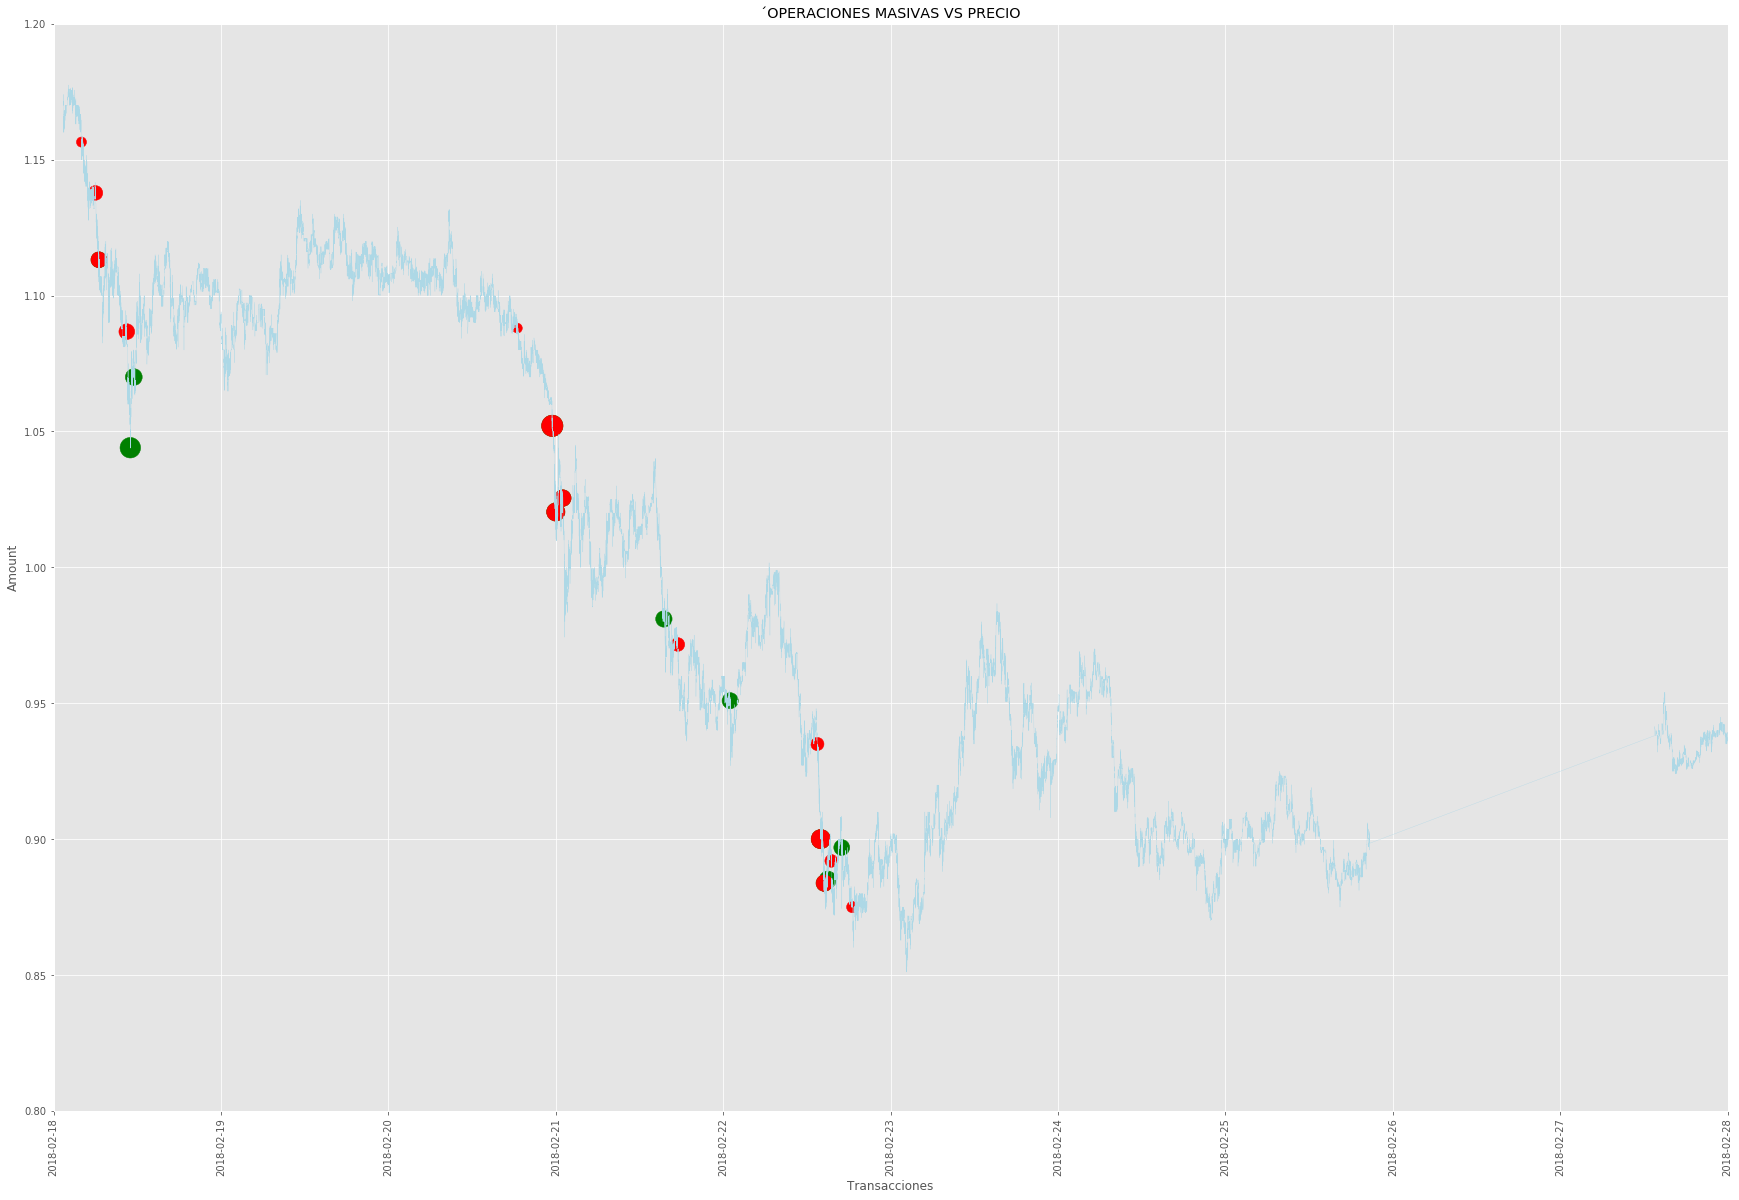

In [22]:
dfAuxCompra = dfAgrupadoUsuarios[dfAgrupadoUsuarios["NUM_T_COMPRA"]>500]
dfAuxVenta = dfAgrupadoUsuarios[dfAgrupadoUsuarios["NUM_T_VENTA"]>500]

# GRANDES OPERACIONES VS PRECIO
pylab.rcParams['figure.figsize'] = (30, 20)
plt.xticks(rotation='vertical')
plt.xlabel('Transacciones')
plt.ylabel('Amount')
plt.title('´OPERACIONES MASIVAS VS PRECIO')


x1 = [pd.to_datetime(d) for d in dfAuxCompra.index]
s1 = [d/2 for d in dfAuxCompra['NUM_T_COMPRA']]
x2 = [pd.to_datetime(d) for d in dfAuxVenta.index]
s2 = [d/2 for d in dfAuxVenta['NUM_T_COMPRA']]

plt.scatter(x1,dfAuxCompra["OPEN"], color=['green'],s =s1)
plt.scatter(x2,dfAuxVenta["OPEN"], color=['red'],s =s2)
plt.plot(dfTransacciones['FECHA'], dfTransacciones['PRICE'],linewidth=0.3,color='lightblue')
plt.ylim(.8, 1.2)
plt.xlim('2018-02-18','2018-02-28')

plt.show()

<div class="alert alert-block alert-success">
Se identifica claramente que cuando existen ventas masivas el precio baja, independientemente de cual es la causa y cual la consecuenta, son procesos correcionados. En el caso de compras ocurre lo mismo, en el lado izquierdo del gráfico se puede identificar claramente. En ese caso hablamos de aproximadamente 5% de subida del precio en un periodo posteior muy inmediato.
</DIV>

<div class="alert alert-block alert-info">
VARIACIONES ACENTUADAS EN EL PRECIO
</div>

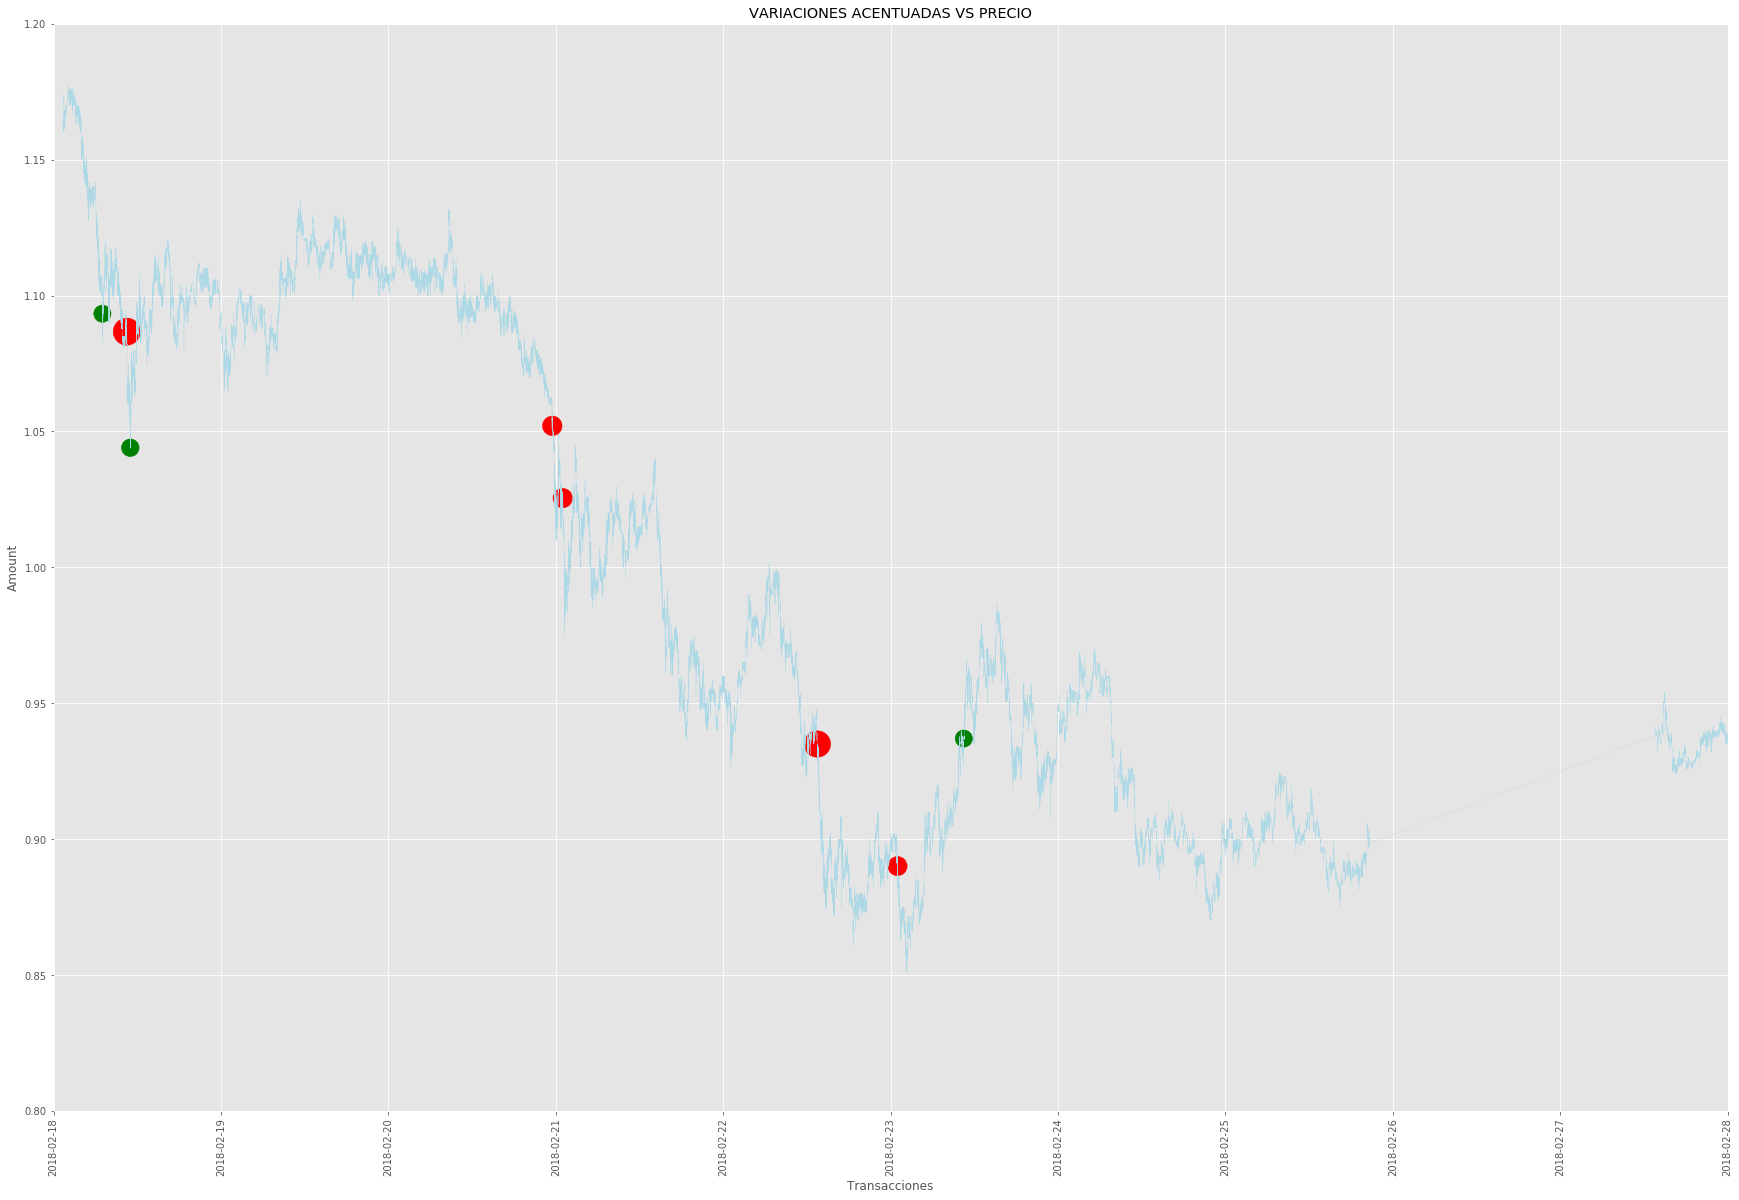

In [33]:
dfAuxSubidas = dfAgrupadoUsuarios[dfAgrupadoUsuarios["VAR_INTERVALO"] > 2.4]
dfAuxBajadas = dfAgrupadoUsuarios[dfAgrupadoUsuarios["VAR_INTERVALO"] < -2.5]

pylab.rcParams['figure.figsize'] = (30, 20)
plt.xticks(rotation='vertical')
plt.xlabel('Transacciones')
plt.ylabel('Amount')
plt.title('VARIACIONES ACENTUADAS VS PRECIO')

x1 = [pd.to_datetime(d) for d in dfAuxSubidas.index]
s1 = [d**2*50 for d in dfAuxSubidas['VAR_INTERVALO']]

x2 = [pd.to_datetime(d) for d in dfAuxBajadas.index]
s2 = [d**2*50 for d in dfAuxBajadas['VAR_INTERVALO']]

plt.scatter(x1,dfAuxSubidas["OPEN"], color=['green'],s=s1)
plt.scatter(x2,dfAuxBajadas["OPEN"], color=['red'], s=s2)
plt.plot(dfTransacciones['FECHA'], dfTransacciones['PRICE'],linewidth=0.3,color='lightblue')
plt.ylim(.8, 1.2)
plt.xlim('2018-02-18','2018-02-28')

plt.show()